<a href="https://nbviewer.jupyter.org/github/codykingham/where_do_you_mean/blob/master/parts_of_speech/experiment.ipynb">best viewed in NBviewer</a>

# Vector space with top most common terms in the Hebrew Bible
**Cody Kingham**<br><br>
<a href="https://www.ames.cam.ac.uk"><img src="../images/frontmatter/CambridgeU_BW.png" height=150px width=150px align="left"></a>

In [27]:
!echo "last updated"; date

last updated
Thu 20 Feb 2020 09:21:35 CET


## Research Question: 
### How do the top most common terms in the Hebrew Bible cluster together when using simple context window as input?


## Brief

In this notebook, we construct a vector space with the top most-common lemmas in the Hebrew Bible. The motivation behind this study is an article by Nick Ellis, Matthew Brook O'Donnel, and Ute Römer: "Usage-Based Language: Investigating the Latent Structures That Underpin Acquisition" ([online](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9922.2012.00736.x)). In the article, the authors argue
> Psychology theory relating to the statistical learning of categories suggests that constructions are robustly learnable when they are (1) Zipfian in their type-token distributions in usage, (2) selective in their verb form occupancy, (3) coherent in their semantics, (4) with a high contingency between form and function. (34)

Ellis, O'Donnel, and Römer base their study of verb argument constructions on the phenomena of [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) in language frequency data. They argue that Zipf's law facilitates language acquisition by providing a few frequent prototypes on which a learner can then relate new data to.

### Method

Inspired by this concept, this study will attempt to cluster the most common terms in Biblical Hebrew on the basis of simple [N-gram](https://en.wikipedia.org/wiki/N-gram) co-occurrence statistics. For this project we use a window size of 3. 

<hr>

# Python

In [2]:
import csv
import collections
from tf.app import use
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np

# import custom modules
from positions import Positions, Getter
from significance import contingency_table

A = use('bhsa', hoist=globals(), silent='deep') # load Hebrew corpus data

## Frequencies distribution 

We gather lemmas in the Hebrew Bible and sort them by frequency. That allows us to plot their rank against their frequency.. 

In [3]:
lexs = collections.Counter()

for l in F.otype.s('lex'):
    lexs[F.lex.v(l)] += F.freq_lex.v(l)

lexs = pd.DataFrame.from_dict(lexs, orient='index', columns=['freq'])
lexs = lexs.sort_values(by='freq', ascending=False)

### Rank vs. Frequency Plot

When the top lemmas' ranks are plotted against their frequency, we can see the familiar Zipfian power-law curve.

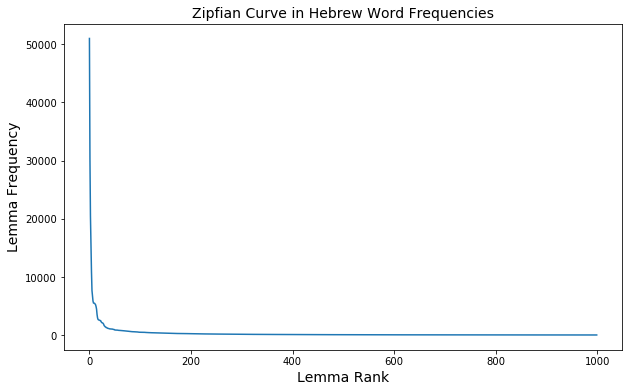

In [4]:
plot = lexs[:1000]
x = np.arange(len(plot))
y = plot.values

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Zipfian Curve in Hebrew Word Frequencies', size=14)
plt.xlabel('Lemma Rank', size=14)
plt.ylabel('Lemma Frequency', size=14)
plt.savefig('figures/hebrew_zipfian_curve.png', dpi=300, bbox_inches='tight')

Let's have a look at the top 100 terms. Note that the lemmas are in [ETCBC transcription](https://annotation.github.io/text-fabric/Writing/Hebrew/) format.

In [5]:
lexs[:100]

,freq
W,51003
H,30392
L,20447
B,15768
>T,10989
MN,7681
JHWH/,6828
<L,5870
>L,5521
>CR,5500


## Degree of Dispersion

Rather than counting simply how frequent a word occurs, does the ranking change if we also consider dispersion throughout the corpus? We can use the "degree of dispersion" ($DP$) measure proposed by Gies 2008, ["Dispersions and adjusted frequencies in corpora"](https://www.researchgate.net/publication/233650934_Dispersions_and_adjusted_frequencies_in_corpora_further_explorations) to measure dispersion throughout the Hebrew Bible.

### Segment the Words

Divide the HB into segments of 100 words and observe frequency of distribution across the sections.

In [6]:
segments = []
seg_size = 100

segment = []
for w in F.otype.s('word'):
    
    segment.append(w)
    if len(segment) == seg_size:
        segments.append(segment)
        segment = []
        
segments.append(segment)

### Count Lexemes by Segment

In [7]:
seg2lex = collections.defaultdict(lambda: collections.Counter())

for i, seg in enumerate(segments):
    
    for w in seg:
        
        lex = L.u(w, 'lex')[0]
        
        seg2lex[i][F.lex.v(lex)] += 1
        
seg2lex = pd.DataFrame(seg2lex).fillna(0)

The datset is shown below. The columns represent sequences of 100 words throughout the Hebrew Bible.

In [8]:
seg2lex.head()

,0,1,2,3,4,5,6,7,8,9,...,4256,4257,4258,4259,4260,4261,4262,4263,4264,4265
B,2.0,1.0,3.0,3.0,3.0,10.0,4.0,4.0,3.0,2.0,...,5.0,2.0,4.0,3.0,5.0,7.0,7.0,7.0,4.0,7.0
R>CJT/,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BR>[,1.0,0.0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
>LHJM/,8.0,5.0,3.0,4.0,6.0,5.0,2.0,5.0,2.0,3.0,...,0.0,0.0,0.0,3.0,0.0,1.0,1.0,4.0,2.0,2.0
>T,4.0,0.0,2.0,5.0,6.0,6.0,3.0,5.0,3.0,2.0,...,0.0,0.0,3.0,0.0,1.0,4.0,1.0,4.0,2.0,2.0


### Apply $DP$

In [9]:
exp = seg2lex.sum() / seg2lex.sum().sum() # expected prop
obs = seg2lex.div(seg2lex.sum(1), axis=0) # observed prop
difs = abs(exp-obs) # difference exp vs. obs
dp = difs.sum(1) / 2

# DP score finalized here, NB 1- to make it more intuitive (Bigger == more distributed)
dp = 1-pd.DataFrame(dp, columns=['Degree of Dispersion']).sort_values(by='Degree of Dispersion')

### Plot and Analyze

Let's plot rank against the degree.

In [10]:
dp.shape

(8773, 1)

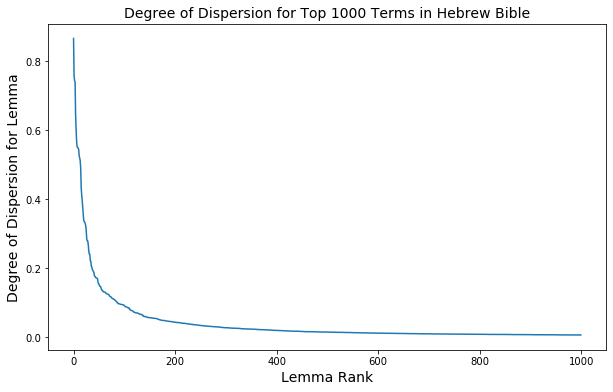

In [11]:
plot = dp[:1000]
x = np.arange(plot.shape[0])
y = plot.values
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Degree of Dispersion for Top 1000 Terms in Hebrew Bible', size=14)
plt.xlabel('Lemma Rank', size=14)
plt.ylabel('Degree of Dispersion for Lemma', size=14)
plt.savefig('figures/degree_of_dispersion_100.png', dpi=300, bbox_inches='tight')
plt.show()

We see a much smoother drop off compared to the raw frequencies. It appears most drop-off occurs from 0 to 200.

Let's look at the degree of dispersion for the top 100 words.

In [12]:
dp.head(100)

,Degree of Dispersion
W,0.866434
L,0.758567
B,0.744386
H,0.740358
MN,0.646352
>T,0.602051
<L,0.568637
>CR,0.552230
JHWH/,0.549956
KL/,0.548928


Overall, the list looks similar to the top-frequency list.

## Vector Experiment

Now we construct a vector space using the tp words. We will select the top 100 most evenly dispersed terms in the corpus. For each of these, we construct a window of 3 words for every sentence a target word occurs in. 

In [13]:
def get_window(word):
    '''
    Build a contextual window, return context words.
    '''
    window = 3
    context = 'sentence'
    confeat = 'lex'
    P = Positions(word, context, A).get
    fore = list(range(-window, 0))
    back = list(range(1, window+1))
    conwords = []
    for pos in (fore + back):
        cword = P(pos, confeat)        
        if cword:
            conwords.append(f'{pos}.{cword}')
    return conwords

wordcons_dict = collections.defaultdict(lambda:collections.Counter())

topwords = set(dp.index[:100])

for w in F.otype.s('word'):
    
    if F.lex.v(w) not in topwords:
        continue
    
    context = get_window(w)
    wordcons_dict[F.lex.v(w)].update(context) 

#### Explore Dataset

In [14]:
data = pd.DataFrame.from_dict(wordcons_dict, orient='index').fillna(0) # convert to dataframe

In [15]:
data.head()

,-3.>T,-2.H,-1.>RY/,1.R>CJT/,2.BR>[,3.>LHJM/,-3.MJM/,-2.HJH[,-1.RQJ</,1.TWK/,...,-2.CM<H=/,-2.BQJ</,-2.CGJWN/,-3.TLPJWT/,1.XVWC/,-3.>YM/,3.>PS_DMJM/,1.KRBL[,-3.SPR==/,1.>BJHJL/
B,368,1650,63.0,6.0,4.0,86.0,27.0,132.0,1.0,312.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
>LHJM/,88,9,2.0,0.0,0.0,10.0,3.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
>T,1027,620,30.0,3.0,0.0,80.0,18.0,15.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,921,3503,163.0,1.0,0.0,22.0,61.0,315.0,4.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W,1676,8933,510.0,6.0,4.0,224.0,51.0,207.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data.shape

(100, 41204)

In [17]:
data.shape[0] * data.shape[1]

4120400

## Apply $\Delta P$ Statistical Significance Normalization

We need an efficient (i.e. simple) normalization method for such a large dataset. Our measure of statistical significance should have no normalcy requirements, since our data is distributed non-normally (Zipfian). $\Delta P$ (NB different from $DP$ above) is a contingency-based significance test that does not assume normalcy (see Ellis 2006, "Language Acquisition", [online](https://academic.oup.com/applij/article/27/1/1/183369)). To calculate $\Delta P$ we need contingency data. This is provided by the custom method, `contingency_table`, defined in this directory.

In [18]:
# contingency table
a,b,c,d,e = contingency_table(data, 0, 1)

In [19]:
# calculate ΔP
delta_p = (a/(a+b)) - (c/(c+d)).fillna(0)

In [20]:
delta_p.shape

(100, 41204)

In [21]:
delta_p.head(10)

,-3.>T,-2.H,-1.>RY/,1.R>CJT/,2.BR>[,3.>LHJM/,-3.MJM/,-2.HJH[,-1.RQJ</,1.TWK/,...,-2.CM<H=/,-2.BQJ</,-2.CGJWN/,-3.TLPJWT/,1.XVWC/,-3.>YM/,3.>PS_DMJM/,1.KRBL[,-3.SPR==/,1.>BJHJL/
B,-0.001036,0.002353,-0.000477,0.000049,0.000029,0.000127,0.000076,-0.000116,0.000002,0.003629,...,-0.000002,-7.248021e-07,-7.248021e-07,-7.248021e-07,-7.248021e-07,-7.248021e-07,-7.248021e-07,-7.248021e-07,-7.248021e-07,-7.248021e-07
>LHJM/,0.001860,-0.016776,-0.001043,-0.000025,-0.000021,-0.000085,-0.000004,-0.000455,-0.000010,-0.000286,...,-0.000002,-6.888570e-07,-6.888570e-07,-6.888570e-07,-6.888570e-07,-6.888570e-07,-6.888570e-07,-6.888570e-07,-6.888570e-07,-6.888570e-07
>T,0.012185,-0.007396,-0.000730,0.000026,-0.000021,0.000444,0.000051,-0.001489,-0.000010,-0.000261,...,-0.000002,-7.124491e-07,-7.124491e-07,-7.124491e-07,-7.124491e-07,-7.124491e-07,-7.124491e-07,-7.124491e-07,-7.124491e-07,-7.124491e-07
H,0.000371,0.004738,-0.000217,-0.000021,-0.000023,-0.000861,0.000142,0.000298,0.000017,-0.000270,...,-0.000002,-7.682704e-07,-7.682704e-07,-7.682704e-07,-7.682704e-07,-7.682704e-07,-7.682704e-07,-7.682704e-07,-7.682704e-07,-7.682704e-07
W,0.000662,0.017336,0.000734,-0.000004,-0.000008,-0.000143,-0.000088,-0.001180,0.000010,-0.000343,...,-0.000003,-8.483210e-07,-8.483210e-07,-8.483210e-07,-8.483210e-07,-8.483210e-07,-8.483210e-07,-8.483210e-07,-8.483210e-07,-8.483210e-07
>RY/,0.003036,-0.016468,-0.000686,0.000062,0.000066,0.002131,0.000443,0.000134,-0.000010,-0.000286,...,-0.000002,-6.885568e-07,-6.885568e-07,-6.885568e-07,-6.885568e-07,-6.885568e-07,-6.885568e-07,-6.885568e-07,-6.885568e-07,-6.885568e-07
HJH[,-0.003413,-0.009327,-0.000528,0.000080,-0.000021,0.001301,0.000011,0.011531,-0.000010,-0.000287,...,-0.000002,-6.921876e-07,-6.921876e-07,-6.921876e-07,-6.921876e-07,-6.921876e-07,-6.921876e-07,-6.921876e-07,-6.921876e-07,-6.921876e-07
<L,-0.000648,0.001638,-0.000588,-0.000025,-0.000021,-0.000452,0.000313,-0.000576,-0.000010,-0.000256,...,-0.000002,-6.976648e-07,-6.976648e-07,-6.976648e-07,-6.976648e-07,-6.976648e-07,-6.976648e-07,-6.976648e-07,-6.976648e-07,-6.976648e-07
PNH/,-0.001612,-0.016103,-0.001107,-0.000025,-0.000021,-0.000213,0.000047,0.001090,-0.000010,-0.000285,...,-0.000002,-6.878662e-07,-6.878662e-07,-6.878662e-07,-6.878662e-07,-6.878662e-07,-6.878662e-07,-6.878662e-07,-6.878662e-07,-6.878662e-07
MJM/,0.000211,-0.011837,-0.001200,0.000346,-0.000021,-0.000532,0.010140,0.000176,-0.000010,-0.000284,...,-0.000002,-6.843596e-07,-6.843596e-07,-6.843596e-07,-6.843596e-07,-6.843596e-07,-6.843596e-07,-6.843596e-07,-6.843596e-07,-6.843596e-07


Now we calculate distance between all 100 words pairwise. We use the cosine distance.

In [22]:
distances_raw = pairwise_distances(np.nan_to_num(delta_p.values), metric='cosine')
dist = pd.DataFrame(distances_raw, columns=data.index, index=data.index)

In [23]:
dist.head(10)

,B,>LHJM/,>T,H,W,>RY/,HJH[,<L,PNH/,MJM/,...,>L=,MLK/,KHN/,KH,<MD[,JHWDH/,JFR>L/,MCH=/,JRWCLM/,DWD==/
B,0.000000,1.136176,0.449470,1.274051,1.091999,1.208063,1.185976,0.373914,1.029701,1.125372,...,1.155051,1.223034,1.169133,1.083704,1.180661,1.164047,1.188045,1.126724,1.226978,1.185339
>LHJM/,1.136176,0.000000,1.171587,1.129920,1.002669,0.699009,1.153233,1.158390,0.952432,0.747337,...,1.048865,0.654576,0.716509,0.738339,1.109602,0.938590,0.902981,0.946278,0.989955,0.952391
>T,0.449470,1.171587,0.000000,1.272447,1.376742,1.266840,0.834470,0.429785,1.079837,1.159008,...,1.152926,1.246368,1.155179,1.138139,0.838661,1.167288,1.234652,0.976435,1.162741,0.955925
H,1.274051,1.129920,1.272447,0.000000,0.887093,1.069290,1.288102,1.187305,0.908632,1.166524,...,1.052637,1.156054,1.204284,1.123678,1.246032,0.978743,0.937861,1.022386,0.638292,0.977780
W,1.091999,1.002669,1.376742,0.887093,0.000000,1.189489,1.548075,1.095528,1.198414,1.190084,...,0.950190,1.125572,1.156962,0.822545,1.488225,0.974410,0.910488,1.012533,1.139481,0.971721
>RY/,1.208063,0.699009,1.266840,1.069290,1.189489,0.000000,1.204252,1.241469,1.027057,0.172043,...,1.119072,0.149897,0.160422,1.048664,1.110192,0.936078,0.942472,1.034089,0.868941,1.101538
HJH[,1.185976,1.153233,0.834470,1.288102,1.548075,1.204252,0.000000,1.125302,1.105253,1.155141,...,0.773682,1.201474,1.145025,1.053290,0.236961,1.082839,1.114936,1.086438,1.046191,1.112164
<L,0.373914,1.158390,0.429785,1.187305,1.095528,1.241469,1.125302,0.000000,1.047564,1.149116,...,1.192918,1.262648,1.200308,1.114750,1.047853,1.123620,1.178626,1.023008,1.136899,1.055572
PNH/,1.029701,0.952432,1.079837,0.908632,1.198414,1.027057,1.105253,1.047564,0.000000,1.001856,...,1.159550,0.993245,1.032225,1.056262,1.033878,0.952963,0.989912,1.017812,0.900894,0.727704
MJM/,1.125372,0.747337,1.159008,1.166524,1.190084,0.172043,1.155141,1.149116,1.001856,0.000000,...,1.121097,0.231643,0.199653,1.096880,1.003705,0.962092,0.987400,1.004815,0.972711,1.038966


## Export Data for Gephi Analysis

We export the data for further analysis in Gephi. To do this, we convert all distances to similarity scores by subtracting distance from 1. 

Similarity ranges from -1 to 1, with -1 being completely dissimilar and 1 being completely similar. 

In [24]:
sims = 1 - dist # make similarity table

sims.head(15)

,B,>LHJM/,>T,H,W,>RY/,HJH[,<L,PNH/,MJM/,...,>L=,MLK/,KHN/,KH,<MD[,JHWDH/,JFR>L/,MCH=/,JRWCLM/,DWD==/
B,1.000000,-0.136176,0.550530,-0.274051,-0.091999,-0.208063,-0.185976,0.626086,-0.029701,-0.125372,...,-0.155051,-0.223034,-0.169133,-0.083704,-0.180661,-0.164047,-0.188045,-0.126724,-0.226978,-0.185339
>LHJM/,-0.136176,1.000000,-0.171587,-0.129920,-0.002669,0.300991,-0.153233,-0.158390,0.047568,0.252663,...,-0.048865,0.345424,0.283491,0.261661,-0.109602,0.061410,0.097019,0.053722,0.010045,0.047609
>T,0.550530,-0.171587,1.000000,-0.272447,-0.376742,-0.266840,0.165530,0.570215,-0.079837,-0.159008,...,-0.152926,-0.246368,-0.155179,-0.138139,0.161339,-0.167288,-0.234652,0.023565,-0.162741,0.044075
H,-0.274051,-0.129920,-0.272447,1.000000,0.112907,-0.069290,-0.288102,-0.187305,0.091368,-0.166524,...,-0.052637,-0.156054,-0.204284,-0.123678,-0.246032,0.021257,0.062139,-0.022386,0.361708,0.022220
W,-0.091999,-0.002669,-0.376742,0.112907,1.000000,-0.189489,-0.548075,-0.095528,-0.198414,-0.190084,...,0.049810,-0.125572,-0.156962,0.177455,-0.488225,0.025590,0.089512,-0.012533,-0.139481,0.028279
>RY/,-0.208063,0.300991,-0.266840,-0.069290,-0.189489,1.000000,-0.204252,-0.241469,-0.027057,0.827957,...,-0.119072,0.850103,0.839578,-0.048664,-0.110192,0.063922,0.057528,-0.034089,0.131059,-0.101538
HJH[,-0.185976,-0.153233,0.165530,-0.288102,-0.548075,-0.204252,1.000000,-0.125302,-0.105253,-0.155141,...,0.226318,-0.201474,-0.145025,-0.053290,0.763039,-0.082839,-0.114936,-0.086438,-0.046191,-0.112164
<L,0.626086,-0.158390,0.570215,-0.187305,-0.095528,-0.241469,-0.125302,1.000000,-0.047564,-0.149116,...,-0.192918,-0.262648,-0.200308,-0.114750,-0.047853,-0.123620,-0.178626,-0.023008,-0.136899,-0.055572
PNH/,-0.029701,0.047568,-0.079837,0.091368,-0.198414,-0.027057,-0.105253,-0.047564,1.000000,-0.001856,...,-0.159550,0.006755,-0.032225,-0.056262,-0.033878,0.047037,0.010088,-0.017812,0.099106,0.272296
MJM/,-0.125372,0.252663,-0.159008,-0.166524,-0.190084,0.827957,-0.155141,-0.149116,-0.001856,1.000000,...,-0.121097,0.768357,0.800347,-0.096880,-0.003705,0.037908,0.012600,-0.004815,0.027289,-0.038966


In [25]:
def getlex(lexstring):
    """Return a lexeme node for a lexeme string"""
    return next((l for l in F.otype.s('lex') if F.lex.v(l) == lexstring), None)

Now we export similarity scores as edges into a format native to Gephi. The data gets exported as a CSV.

In [26]:
node_maps = {}
nodes = []
edges = []

# make nodes
for i,word in enumerate(sims):
    lexn = getlex(word)
    label = F.gloss.v(lexn) # Give label feature here
    nodes.append([i, label])
    node_maps[word] = i
    
# make edges
for word in sims.columns:
    these_sims = sims[word][sims[word] > 0]
    for coword in these_sims.index:
        source = node_maps[word]
        target = node_maps[coword]
        weight = sims[word][coword]
        edges.append([source, target, weight])

# export csv's
with open('gephi_data/top_nodes.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['ID', 'Label'])
    writer.writerows(nodes)
with open('gephi_data/top_sim_edges.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Source', 'Target', 'Weight'])
    writer.writerows(edges)

## Gephi Results

### Whole Cluster

<img src="figures/whole_cluster.png" height=800px width=800px>

## Dendrogram with $\Delta P$ scores

The Gephi analysis gives us general clusters. But we can also make a precise cluster using a dendrogram.

In [27]:
links = linkage(delta_p, metric='cosine', method='complete')

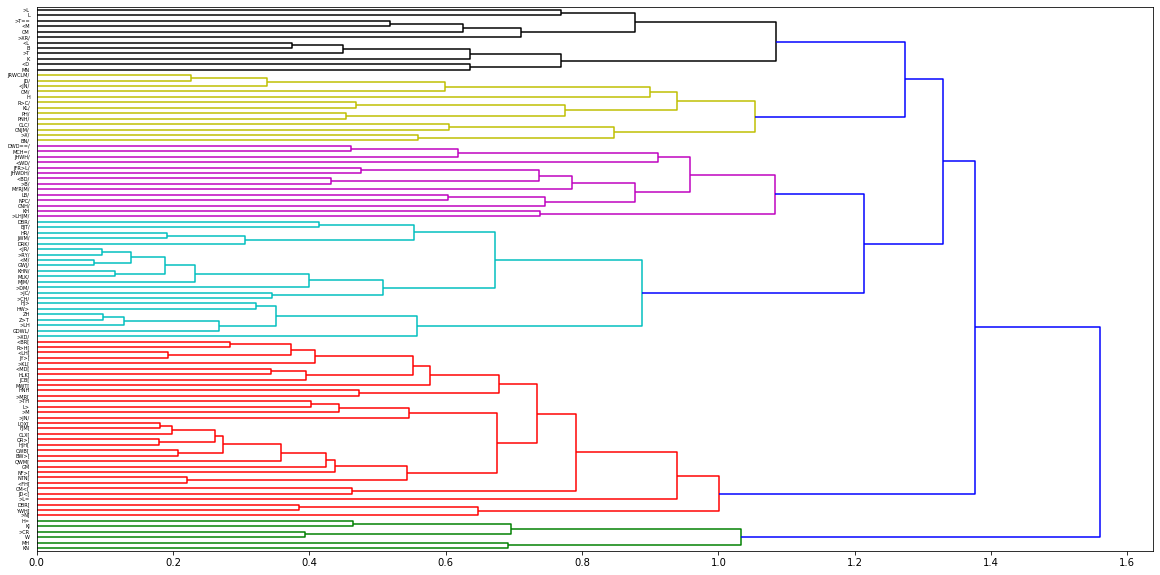

In [28]:
plt.figure(figsize=(20, 10))
dendrogram(links, labels=delta_p.index, orientation='right')
plt.savefig('figures/linkage_clusters.png', dpi=300, bbox_inches='tight')
plt.show()